In [32]:
from os import listdir

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [6]:
dataset = 'barents'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

files = train_files + val_files + test_files

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

In [7]:
lons, lats = grid["lons"].tolist(), grid["lats"].tolist()

In [9]:
def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

In [10]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0) + grid['land']*10)

In [11]:
date = "2021-06-21"
index = files.index(date +".pt")
context = files[index-6:index+1]

In [12]:
context

['2021-06-15.pt',
 '2021-06-16.pt',
 '2021-06-17.pt',
 '2021-06-18.pt',
 '2021-06-19.pt',
 '2021-06-20.pt',
 '2021-06-21.pt']

In [14]:
if date[:4] == "2021":    
    images = [preprocess_image(torch.load(folder_test + context[i])["jaxa.sic"])\
                                for i in range(0, len(context))]
else:
    if date[:4] == "2020":
        images = [preprocess_image(torch.load(folder_val + context[i])["jaxa.sic"])\
                                    for i in range(0, len(context))]
    else:
        images = [preprocess_image(torch.load(folder_train + context[i])["jaxa.sic"])\
                                    for i in range(0, len(context))]

In [15]:
images_tensor = torch.stack(images).to(device)
images_tensor.shape

torch.Size([7, 360, 500])

In [56]:
from os import listdir

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def get_files(folders, dataset: str) -> list:
    train_files, val_files, test_files = sorted([file for file in listdir(folders[0])])[1346:],\
                                         sorted([file for file in listdir(folders[1])]),\
                                         sorted([file for file in listdir(folders[2])])

    files = train_files + val_files + test_files
    return files

def get_coords(grid) -> tuple:
    lons, lats = grid["lons"].reshape(-1).tolist(), grid["lats"].reshape(-1).tolist()
    return {"lons":lons, "lats":lats}

def get_model(model_name: str, device: str = "cpu"):
    return torch.load(model_name).to(device)

def unet_inference(model, folders: list, files: list, date: str, grid) -> dict():
    def round_tensor(data: torch.Tensor) -> torch.Tensor:
        output_round = torch.round(data)
        output_round[output_round <= 0] = 0
        return output_round
    
    def preprocess_image(tensor: torch.Tensor, grid) -> torch.Tensor:
        return (torch.nan_to_num(tensor, nan=-10.0) + grid['land']*10)
    
    index = files.index(date +".pt")
    context = files[index-6:index+1]
    pred_dates = files[index+1:index+4]
    
    if date[:4] == "2021":    
        images = [preprocess_image(torch.load(folders[2] + context[i])["jaxa.sic"], grid)\
                                for i in range(0, len(context))]
    else:
        if date[:4] == "2020":
            images = [preprocess_image(torch.load(folders[1] + context[i])["jaxa.sic"], grid)\
                                        for i in range(0, len(context))]
        else:
            images = [preprocess_image(torch.load(folders[0] + context[i])["jaxa.sic"], grid)\
                                        for i in range(0, len(context))]
            
    images_tensor = torch.stack(images).to(device)
    model_output = round_tensor(model(images_tensor[None, :, :, :])[0]).detach().numpy()
    result = {pred_dates[i][:-3]:model_output[i].reshape(-1) for i in range(len(model_output))}
    return result

def main_inference(dataset: str, date: str, model_name: str):
    folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
    files = get_files([folder_train, folder_val, folder_test], dataset)
    grid = torch.load(dataset + "/train/grid.pt")
    
    model = get_model(model_name)
    
    pred_sic = unet_inference(model, [folder_train, folder_val, folder_test], files, date, grid)
    coords = get_coords(grid)
    return {"coords":coords, "magn":pred_sic}

In [57]:
inference_output = main_inference("barents", "2021-06-21", "UNet_no_gfs_default.pt")

In [61]:
inference_output["magn"]['2021-06-22'].reshape(360, 500)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
%debug

> /tmp/ipykernel_3749/741973816.py(42)<dictcomp>()
     40     images_tensor = torch.stack(images).to(device)
     41     model_output = round_tensor(model(images_tensor[None, :, :, :])[0]).detach().numpy()
---> 42     result = {pred_dates[i]:model_output[i].reshape(-1) for i in range(len(model_output))}
     43     return result
     44 

ipdb> len(model_output)
3
ipdb> len(pred_dates)
2
ipdb> exit


In [45]:
len(files)

2543

In [16]:
model = torch.load("UNet_no_gfs_default.pt").to(device)

In [17]:
output = model(images_tensor[None, :, :, :])[0]

In [18]:
output[1]

tensor([[ 4.8220e-03,  1.8035e-03,  2.2679e-03,  ...,  2.5680e-03,
          4.0121e-03, -3.4120e-03],
        [ 1.9737e-03,  2.1838e-03,  3.4603e-03,  ...,  5.2747e-03,
          5.9867e-03, -6.9293e-04],
        [-1.0076e-03,  9.0890e-05,  2.7199e-04,  ...,  1.6854e-03,
          3.5428e-03, -1.4370e-03],
        ...,
        [-2.0333e-03,  2.6836e-04, -3.4590e-04,  ...,  2.1198e-03,
          3.2956e-03, -2.5631e-04],
        [ 3.6875e-03,  3.0155e-03,  2.1151e-03,  ...,  4.4594e-03,
          6.3785e-03, -1.0670e-03],
        [-4.8490e-03,  1.6724e-03, -8.7257e-04,  ...,  4.9929e-04,
          5.7147e-04, -6.8593e-03]], grad_fn=<SelectBackward>)

In [19]:
torch.round(output[1])

tensor([[0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.],
        [-0., 0., 0.,  ..., 0., 0., -0.],
        ...,
        [-0., 0., -0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.],
        [-0., 0., -0.,  ..., 0., 0., -0.]], grad_fn=<RoundBackward>)

In [30]:
output_round = torch.round(output)
output_round[output_round <= 0] = 0

In [27]:
output_round[output_round <= 0] = 0

In [37]:
output_final = output_round.detach().numpy()

In [41]:
output_final[0].reshape(-1).shape

(180000,)

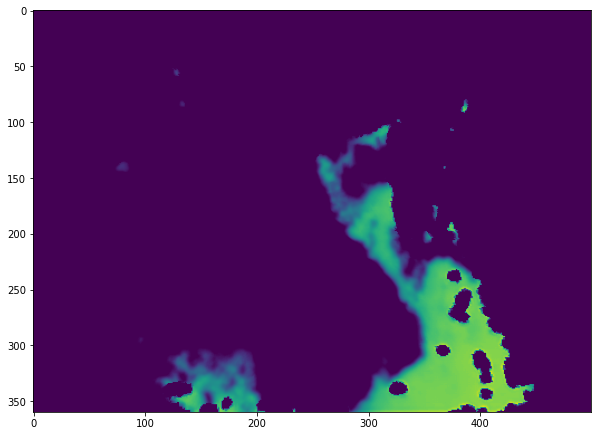

In [63]:
from pylab import *

plt.figure(figsize=(10,10))
axs = imshow(output_round[0].detach().numpy())

### Inference test

In [65]:
from inference import main_inference

ModuleNotFoundError: No module named 'inference'

In [1]:
%load_ext autoreload
%autoreload 2

from inferences.inference import main_inference

In [15]:
%load_ext autoreload
%autoreload 2

from inferences.inference import main_inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
inference_output = main_inference("barents", "2021-06-21", "UNet_no_gfs_default.pt")

In [4]:
import json

def save_results(inference_output, dataset:str, date:str, model:str):
    with open(dataset + "_" + date + "_" + model +'.json', 'w') as f:
        json.dump(inference_output, f)

In [3]:
import json

In [6]:
inference_output

{'coords': {'lons': [32.37467575073242,
   32.46427536010742,
   32.55398941040039,
   32.64380645751953,
   32.733734130859375,
   32.823768615722656,
   32.913909912109375,
   33.00415802001953,
   33.09451675415039,
   33.18497848510742,
   33.275550842285156,
   33.36622619628906,
   33.457008361816406,
   33.54789733886719,
   33.638893127441406,
   33.72999572753906,
   33.82120132446289,
   33.912513732910156,
   34.003929138183594,
   34.09545135498047,
   34.18708038330078,
   34.278812408447266,
   34.37065124511719,
   34.462589263916016,
   34.55463409423828,
   34.646785736083984,
   34.739036560058594,
   34.83139419555664,
   34.923851013183594,
   35.016414642333984,
   35.10908126831055,
   35.201847076416016,
   35.294715881347656,
   35.38768768310547,
   35.48076248168945,
   35.57394027709961,
   35.66721725463867,
   35.76059341430664,
   35.85407257080078,
   35.947654724121094,
   36.04133224487305,
   36.13511276245117,
   36.22899627685547,
   36.3229751586914